<a href="https://colab.research.google.com/github/dgallacher1/NotebookProjects/blob/main/RadonFlowguides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New flowguide radon deposition calculations

## Introduction

In this analysis we calculate the radon load onto the flowguides during the sanding and coating process at Carleton. 
<br>

<br>
References:

*   [Flowguide sanding and coating plan Rev 2. ](https://docs.google.com/document/d/1zNNXOKdvugkTw49SNY5kLJNqcJyWCCWRszmMSMOOhBw/edit#)
*    [Backgrounds from Rn daughter deposition on flowguides during sanding](https://www.snolab.ca/deap/private/TWiki/bin/view/Main/DeapStr2015x001) 
*  [DEAP-3600 AV surface backgrounds from radon exposure](https://https://www.snolab.ca/deap/private/TWiki/bin/view/Main/DeapStr2014x009) 



Radon-222 is a radioactive gas present in small ammounts in air. It is produced due to the naturally occuring U238 in all materials, since Rn222 is a gas at STP, it is particularly pernicious and can lead to build-up of long-lived alpha-decaying radioisotopes that can harm a direct dark matter search experiment such as DEAP-3600.

<br>
The Rn222 chain is shown below:

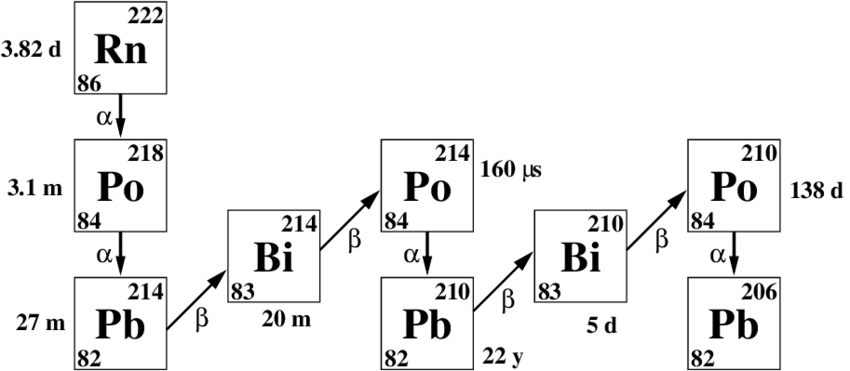


Where the long lived Pb210 is embedded inside of materials through diffusion of Rn222 as well as being deposited onto the surface.
<br>
The alpha decaying Po210 from the long lived Pb210 is the primary concern.
<br>

## Radon load calculations


This subsection details the estimation of the total Rn222 load inside the glovebox during each stage of processing.

<br>
The processing will occur in 6 main stages


1.   Loading (1 day)
2.   Sanding (5 days)
3.   Drying  (1 week)
4.   Coating (5 days)
5.   Curing  (1 week)
6.   Assembly (1 day)



In [ ]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
mp.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 10]
import numpy as np
import math
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import gaussian_kde
import scipy as sp
import seaborn as sns


#Read in table of Radon emanation data from drive
#Google nonsense
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

#Read the google sheet with radon data
worksheet = gc.open('RadonLoadTable').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
#Import raw data into pandas df
thedata = pd.DataFrame.from_records(rows[1:])
thedata.columns = rows[:1][0]
pd.to_numeric(thedata['Emanation Rate(Atoms/hr)'], downcast="float")
#Show the data to ensure its loaded correctly
display(thedata)


,Material,Emanation Rate(Atoms/hr),Process
0,Gloves x4\n,20,Static
1,Glove ports x4 (Acrylic?),0.35,Static
2,Lexan Windows,2,Static
3,"Aluminum FG Holder, knots, Bolts",5,Static
4,Stainless steel,1,Static
5,Copper tube,0.1,Static
6,Plastic spray gun,0.1,Static
7,Extension cord,0.1,Static
8,Tygon tubing,1,Static
9,Silicone sealant,1,Static


Following procedure from DEAP-STR-2015-001 <br>
Overall Rn-222 activity in glovebox can be represented as a sum of contritbutions due to various components:

1.   Activity of LN2 Purge
2.   Activity of static components inside glovebox(Residual)
3.   Activity due to leakage from air outside glovebox

Then for each stage of the process as listed above, we have additional contributions due to the residual components introduced at each stage.
<br>
For the sanding process:

1.   Activity of the water
2.   Activity of additional components inside glovebox

For the coating process:

1.   Activity of the pyrene+PS solution
2.   Activity of additional components inside glovebox





In [ ]:
#Input parameters here, time base in  for inputs
#Approximate 1 day of loading, 1 day of assembly, 1 week of drying and 1 week of curing
days_static = 7*5*4
#Approx 5 days, 8 hours per day in "Sanding configuration"
days_sanding = 7 
#Approx 5 days, 8 hours per day in "Coating configuration"
days_coating = 21

#Additional tunable input parameters
act_room_air = 3 #Bq/m3, from rad meter in lab
Pb210_act_water = 3 #Bq/m3, activity of disolved of Pb210
solubility_water = 0.5 #Solubulity of Rn222 in water from DEAP-STR-2015-001
water_volume = 0.5 #m3, approx ammount of water added to glovebox
#a0_ln2 = 5e-4 #Baseline activity in Bq/m3 DEAP-STR-2015-001
a0_ln2 = 7.5e-4 #Baseline activity in Bq/m3 from Pushpa's measurements at Carleton https://www.snolab.ca/deap/private/TWiki/bin/view/DEAP3/AnalysisNotex568
flowrate = 1 #Number of GB volume turnovers per hour
eff_degas = 0.9 #Efficiency for removing gas from UPW based on oxygen removal efficiency for degassser
upw_flowrate = 0.25*0.227125#[m3/hr] Convert 0.25 gallon/min to m3/hr

#Static input parameters
SA_flowguides = 0.75 #m2 
Vol_glovebox = 0.85 #m3 
Pb210_lifetime = 22.3*365*24 #half life of Pb210 in hrs
Rn222_lifetime = 3.82*24 #half life of Rn222 in hrs

In [ ]:
#Read in data from spreadsheet, it's important that the process names are constant in the table or they won't be read here
total_static = thedata.loc[thedata['Process']=="Static","Emanation Rate(Atoms/hr)"].astype(float).sum()
print("Total Rn222 emanation rate due to static components = {}".format(total_static))
#total_static = 2000 #Rn atoms/hr A guess, comment me out when table is full

total_sanding = thedata.loc[thedata['Process']=="Sanding","Emanation Rate(Atoms/hr)"].astype(float).sum()
print("Total Rn222 emanation rate due to sanding components = {}".format(total_sanding))
#total_sanding = 10 #Rn atoms/hr A guess, comment me out when table is full

total_coating = thedata.loc[thedata['Process']=="Coating","Emanation Rate(Atoms/hr)"].astype(float).sum()
print("Total Rn222 emanation rate due to coating components = {}".format(total_coating))
#total_coating = 10 #Rn atoms/hr A guess, comment me out when table is full

Total Rn222 emanation rate due to static components = 220.95000000000002
Total Rn222 emanation rate due to sanding components = 8.549999999999999
Total Rn222 emanation rate due to coating components = 3.2


Below we define several functions for calculating the activity due to different components of the overall activity within the glovebox:

In [ ]:
#Heaviside with offset, takes in 2 np arrays, t and t0
def Heavy(t,t0,vFalse,vTrue):
    return np.where( t<t0 , np.full_like(t,vFalse) , np.full_like(t,vTrue))

#np.exp() Exponential with edge handling for code readability
def Expo(val):
    return np.exp(val,where = val < np.full_like(val,60),out=np.full_like(val,0.0))

#Residual contribution due to the activity starting from the room air at t0, our time base is in hours
def Act_Res(a_rm,tau_rn,tau_flow,t0,t):
  return a_rm*Expo(-(t-t0)/tau_flow)*Expo(-(t-t0)/tau_rn)

#Activity contribution due to LN2 boil-off
def Act_LN2(a0_ln2,tau_flow,t):
  return a0_ln2*(1.0-Expo(-t/tau_flow))

#Water contamination into glovebox volume, distinct from Po210 dissolved into water
#We use a degasser so this equation is modified compared to DEAP STR-2015-001 with an efficiency term
def Act_UPW(a_room,V_upw,S,tau_flow,tau_rn,eff_degas,t0,t):
  _t0 = np.full_like(t,t0)
  return  Heavy(t,_t0,0.0,1.0)*a_room*V_upw*S*Expo(-(t-t0)/tau_flow)*Expo(-(t-t0)/tau_rn)*(1-eff_degas)

#Activity due to emanated radon inside GB between t0 and tStop
def Act_Emn(R_rn,tau_rn,tau_flow,t0,tS,t):
    _t0 = np.full_like(t,t0)
    _tS = np.full_like(t,tS)
    #Start emanating at t0, convert Radon atoms emitted into Bq
    #a_em = Heavy(t,_t0,0.0,1.0)* R_rn*(math.log(2)/(tau_rn*3600)) * (1/tau_flow+1/tau_rn)*(1.0 - Expo(-(t-t0)/tau_flow)*Expo(-(t-t0)/tau_rn))  
    a_em = Heavy(t,_t0,0.0,1.0)* R_rn * (tau_flow*tau_rn)/(tau_flow+tau_rn)*(1.0 - Expo(-(t-t0)/tau_flow)*Expo(-(t-t0)/tau_rn))  
    a_em*=(math.log(2)/(tau_rn*3600)) #Convert to A(t) from N(t)
    #If we stop emanating, we decay away while we flush the GB
    _tS_index = np.argmin(np.abs(t-_tS))
    a_stop = a_em[_tS_index]
    return Heavy(t,_tS,a_em,a_stop*Expo(-(t-tS)/tau_flow)*Expo(-(t-tS)/tau_rn))

#Activity due to emanated radon inside GB between t0 and tStop with no flow
def Act_Emn_Noflow(R_rn,tau_rn,t0,tS,t):
    _t0 = np.full_like(t,t0)
    _tS = np.full_like(t,tS)
    a_em = Heavy(t,_t0,0.0,1.0)* R_rn * tau_rn *(1-Expo(-(t-t0)/tau_rn))
    a_em*=(math.log(2)/(tau_rn*3600)) 
    #Start emanating at t0, convert Radon atoms emitted into Bq
    #If we stop emanating, we decay away while we flush the GB
    _tS_index = np.argmin(np.abs(t-_tS))
    a_stop = a_em[_tS_index]
    return Heavy(t,_tS,a_em,a_stop*Expo(-(t-tS)/tau_rn))

Here we use a time base in hours, so the overall specific Radon-222 activity in the glovebox can be expressed as:
<br>
\begin{equation}
a (t) = a_{LN2}(t) + a_{res.}(t) + a_{Emanation}(t) + a_{UPW}(t) \;\:\: [Bq_{Rn222}/m^{3}]
\end{equation}
<br>
<br>

These components represent the main Radon contributors inside the glovebox, and are represented as follows:
<br>
The baseline activity of the LN2 purge gas:
<br>
<br>
\begin{equation}
a_{LN2}(t) = a^{0}_{LN2} \, \times \Big(1.0 - e^{-t/\tau_{flow}}\Big)
\end{equation}
<br>
<br>

Where $a^{0}_{LN2}$ represents the bulk baseline activity of the LN2 purge gas of *0.5 mBq/m3* and $\tau_{flow}$ represents the half-life of GN2 inside the glovebox represented as:
<br>
\begin{equation}
\tau_{flow} = \frac{V_{glovebox}}{F\ln{2}}
\end{equation}
<br>
Where 'F' is the flowrate in the glovebox given in turnovers/hour.
<br>
<br>
The activity of the UPW introduced into the glovebox during sanding can be represented as:
<br>
<br>
\begin{equation}
a_{UPW}(t) = \Theta(t-t_{w})\, a_{room}S\,\times \, e^{-(t-t_{w})/\tau_{flow}}\,e^{-(t-t_{w})/\tau_{Rn}}
\end{equation}
<br>
<br>
Where 'S' is the solubulity of Radon-222 into water,$a_{room}$ is the baseline Rn activity of the room air measured in the lab,$\tau_{Rn}$ is the halflife of Rn222 in the same timebase, $t_{w}$ is the time when water is introduced into the glovebox and $\Theta$ is the heaviside step function.
<br>
Residual air from comissioning the glovebox can be represented by the term:
<br>
<br>
\begin{equation}
a_{res.}(t) = a_{room}\, e^{-(t-t_{0})/\tau_{flow}}\,e^{-(t-t_{0})/\tau_{Rn}}
\end{equation}
<br>
<br>
Where, $t_{0}$ is the time at which the procedure starts, and lastly the emanated radon from components inside the glovebox is represented in two components:
<br>
<br>
\begin{equation}
a^{i}_{Emanation}(t) = \Theta(t-t_{i}) \, \frac{R_{Rn}\,\ln{(2)}}{3600\,\tau_{rn}} \frac{\tau_{flow}\tau_{Rn}}{\tau_{flow}+\tau_{Rn}}\times \Big(1.0-e^{-(t-t_{i})/\tau_{flow}}\,e^{-(t-t_{i})/\tau_{Rn}}\Big)
\end{equation}
<br>
\begin{equation}
  a^{s}_{Emanation}(t) = \Theta(t-t_{s})\, a^{i}_{Emanation}(t_{s})\,e^{-(t-t_{s})/\tau_{flow}}\,e^{-(t-t_{s})/\tau_{Rn}}
\end{equation}
<br>
<br> 
\begin{equation}
  a_{Emanation}(t)=\begin{cases}
    a^{i}_{Emanation}(t), & \text{if $t_{i}<t<t_{s}$}.\\
    a^{s}_{Emanation}(t), & \text{if $t>t_{s}$}.\\
    0, & \text{otherwise}.
  \end{cases}
\end{equation}
<br>
<br>
Where, $R_{Rn}$ is the rate of Rn-222 atoms emitted per hour by the materials inside the glovebox, $t_{i}$ is the time when these components are inserted into the glovebox (For static components $t_{i}$ == $t_{0}$) ,$t_{s}$ is the time when they are removed from the glovebox, and so the rate will decrease over time as the Radon is flushed by the purge and decays away. Here, $a^{i}_{Emanation}(t)$ comes from solving the following differential equation:
<br>
\begin{equation}
  \frac{dN}{dt}(t) = R_{Rn} - N(t)\Big(\frac{1}{\tau_{Rn}}+\frac{1}{\tau_{flow}}\Big) 
\end{equation}
<br>


In [ ]:
#Intiliaze parameters, time base is in hrs
t0 = 0.0
tEnd = 24*days_static
numPoints = tEnd*100
tt = np.linspace(1e-5,tEnd,numPoints) #1/100 hr time bining
tau_flow = Vol_glovebox/(flowrate*math.log(2)) #Time constant of purge flow in hrs
#Get the activity contribution due to the purge gas vs time (Over 5 weeks)
a_ln2 = Act_LN2(a0_ln2,tau_flow,tt)


#Get the activity contribution from residual room air in GB
a_res = Act_Res(act_room_air,Rn222_lifetime,tau_flow,t0,tt) #Bq/m3

#Get the activity due to water added to glovebox
tW = 24 #Time we add water to GB
a_upw = Act_UPW(act_room_air,water_volume,solubility_water,tau_flow,Rn222_lifetime,eff_degas,tW,tt)/Vol_glovebox #Bq/m3

#Get the activity due to emanation for each component

#Static components
t0_static = 0.0
tS_static = 24*days_static
a_static = Act_Emn(total_static,Rn222_lifetime,tau_flow,t0_static,tS_static,tt)/Vol_glovebox #Bq/m3

#Sanding components, we assume here that the sanding components are inside the glovebox the entire 5 days
t0_sanding = 24.0 #Wait a day before sanding
tS_sanding= t0_sanding+24*days_sanding 
a_sanding = Act_Emn(total_sanding,Rn222_lifetime,tau_flow,t0_sanding,tS_sanding,tt)/Vol_glovebox #Bq/m3

#Coating components, similar to before, we assume the coating materials are inside the glovebox the entire 5 days
t0_coating = tS_sanding+24*7 #Wait a week before coating
tS_coating = t0_coating+24*days_coating 
a_coating = Act_Emn(total_coating,Rn222_lifetime,tau_flow,t0_coating,tS_coating,tt)/Vol_glovebox #Bq/m3

#Total emanated activity
a_emanation = a_static + a_sanding + a_coating


Radon Concentration due to Emanation = 0.000661 Bq/m3
Radon Concentration due to LN2 Purge = 0.00075 Bq/m3


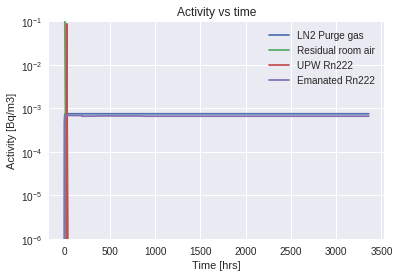

In [ ]:
##Plot the activities to compare
plt.plot(tt,a_ln2,label="LN2 Purge gas")
plt.plot(tt,a_res,label="Residual room air")
plt.plot(tt,a_upw,label="UPW Rn222")
plt.plot(tt,a_emanation,label="Emanated Rn222")

#Formatting
plt.title("Activity vs time")
plt.legend()
plt.xlabel("Time [hrs]")
plt.ylabel("Activity [Bq/m3]")
#plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-6,1e-1)

print("Radon Concentration due to Emanation = {:0.3} Bq/m3".format(a_emanation[-1]))
print("Radon Concentration due to LN2 Purge = {} Bq/m3".format(a_ln2[-1]))


(0.0001, 0.1)

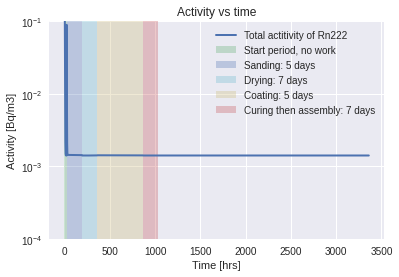

In [ ]:
#Total activity vs time
a_total = a_res + a_ln2 + a_upw + a_emanation
plt.plot(tt,a_total,label="Total actitivity of Rn222",lw=2)

plt.axvspan(0, t0_sanding, color='C1', alpha=0.3, lw=0,label="Start period, no work")
plt.axvspan(t0_sanding, tS_sanding, color='C6', alpha=0.3, lw=0,label="Sanding: 5 days")
plt.axvspan(tS_sanding, t0_coating, color='C5', alpha=0.3, lw=0,label="Drying: 7 days")
plt.axvspan(t0_coating, tS_coating, color='C4', alpha=0.3, lw=0,label="Coating: 5 days")
plt.axvspan(tS_coating, tS_coating+24*7, color='C2', alpha=0.3, lw=0,label="Curing then assembly: 7 days")

#Formatting
plt.title("Activity vs time")
plt.legend()
plt.xlabel("Time [hrs]")
plt.ylabel("Activity [Bq/m3]")
#plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4,1e-1)

We can clearly see the effect of starting and stopping the various stages in the fabrication. 
<br>

Next we (very) conservatively assume that **all** activity in the glovebox results in Rn222 on the flowguides. We then assume that half of these decays results in Po218 on the flowguides (The other half are ejected) and that all Po218 decays down to Pb210 quickly. The expected surface activity is then just the Pb210 decay rate, which supports the alpha decays of Po210 inside DEAP.
<br>
This requires that the total activity of Pb210 aquired onto the flowguides can be represented as:
<br>
<br>
\begin{equation}
a_{Pb210, FGs} = \frac{V_{GB}}{2\,\lambda_{Rn}}\times\frac{\lambda_{Pb210}}{A_{FG}}\times\int_{t_{0}}^{t_{f}} a(t)\,dt
\end{equation}
<br>
Where $\lambda_{Rn}$ is the decay constant for Rn222, $\lambda_{Pb210}$ is the decay constant for Pb210, $A_{FG}$ is the surface area of the flowguides and $t_{f}$ is the stopping time for the entire process.

In [ ]:
#Starting from 23 hrs when we take the flowguides out of the cannister before sanding
tStart = np.full_like(tt,23)
tStart_index = np.argmin(np.abs(tt-tStart))

activity_integral = np.trapz(a_total[tStart_index:],tt[tStart_index:])
activity_integral *= Vol_glovebox #Scale to volume inside GB
lambda_rn222 = math.log(2)/(Rn222_lifetime*3600)
#Assuming half of all radon decays on the surface leads to Po218
#and that all Po218 decays down to Pb210 with no loss
N_Pb210 = activity_integral/lambda_rn222/2

#Calculate the effective surface activity given the flowguide SA
lambda_pb210 = math.log(2)/(Pb210_lifetime*3600)
Surf_act = N_Pb210*lambda_pb210/SA_flowguides*1000 #mBq/m2
print("Surface activity on FGs = {:0.3f} mBq (Pb210)/m2".format(Surf_act))

#N_leakage (3 yr LT)/mBq/m2
N_leak_avg = 3.58e-3 #ROI events in 3 yr LT/mBq Pb210/m2 (All surfaces and systematics averaged) , from David's analysis on Slow WLS coatings
print("Expected background events in 3 yrs LT = {:0.4}".format(N_leak_avg*Surf_act))

Surface activity on FGs = 1.283 mBq (Pb210)/m2
Expected background events in 3 yrs LT = 0.004592


We see from above that the very conservative assumptions on the glovebox activity result in a surface activity of ~1.283 mBq/m2 for the nominal parameters. 

We also want to see what potential activity we will have if we stop the flow, and how that effects the overall background rate. This is done below.

In [ ]:
#Static components
t0_static = 0.0
tS_static = 24*days_static
flowrate = 1
tau_flow = Vol_glovebox/(flowrate*math.log(2)) #Time constant of purge flow in hrs
a_static = Act_Emn_Noflow(total_static,Rn222_lifetime,t0_static,tS_static,tt)/Vol_glovebox #Bq/m3
Vol_chamber = 0.01
#a_static = Act_Emn_Noflow(32000,Rn222_lifetime,t0_static,tS_static,tt)/Vol_chamber #Bq/m3


#Sanding components, we assume here that the sanding components are inside the glovebox the entire 5 days
t0_sanding = 24.0 #Wait a day before sanding
tS_sanding= t0_sanding+24*days_sanding 
a_sanding = Act_Emn_Noflow(total_sanding,Rn222_lifetime,t0_sanding,tS_sanding,tt)/Vol_glovebox #Bq/m3

#Coating components, similar to before, we assume the coating materials are inside the glovebox the entire 5 days
t0_coating = tS_sanding+24*7 #Wait a week before coating
tS_coating = t0_coating+24*days_coating 
a_coating = Act_Emn_Noflow(total_coating,Rn222_lifetime,t0_coating,tS_coating,tt)/Vol_glovebox #Bq/m3

#Total emanated activity
a_total_noflow = a_static + a_sanding + a_coating
plt.plot(tt,a_total_noflow)
plt.ylabel("Bq/m3")
plt.title("Emanation with no glovebox flow")
plt.xlabel("Time [hrs]")

#Starting from no flow.
tStart = np.full_like(tt,0)
tStart_index = np.argmin(np.abs(tt-tStart))
#How many hours do we have this exposure for?
nHours = 48
tEnd = np.full_like(tt,nHours)
tEnd_index = np.argmin(np.abs(tt-tEnd))
print("Activtiy at {} hours = {}",nHours,a_total_noflow[tEnd_index])

activity_integral = np.trapz(a_total_noflow[tStart_index:tEnd_index],tt[tStart_index:tEnd_index])
activity_integral *= Vol_glovebox #Scale to volume inside GB
lambda_rn222 = math.log(2)/(Rn222_lifetime*3600)
print(lambda_rn222)
#Assuming half of all radon decays on the surface leads to Po218
#and that all Po218 decays down to Pb210 with no loss
N_Pb210 = activity_integral/lambda_rn222/2

#Calculate the effective surface activity given the flowguide SA
lambda_pb210 = math.log(2)/(Pb210_lifetime*3600)
Surf_act = N_Pb210*lambda_pb210/SA_flowguides*1000 #mBq/m2
print("Additional Surface activity on FGs with no flow  for {} hours = {:0.3f} mBq (Pb210)/m2".format(nHours,Surf_act))

#N_leakage (3 yr LT)/mBq/m2
N_leak_avg = 3.58e-3 #ROI events in 3 yr LT/mBq Pb210/m2 (All surfaces and systematics averaged) , from David's analysis on Slow WLS coatings
print("Additional expected background events in 3 yrs LT = {:0.4}".format(N_leak_avg*Surf_act))

As shown above, turning off the flow will have a siginicant effect on the expected surface activity, we will take measures to ensure that LN2 purge flow is consistent for the duration of the flowguide coating and assembly. At a purge rate of 1 GB/hr we expect to go through 250 L dewars at a rate of ~0.5 dewars/day , and will need to keep a consistent supply. In case of emergency we have made arragnements to procure LN2 from Science Stores at Carleton as well as from the nEXO group. 

# Time dependent deposition and background comparisons

In this section we try to handle the time dependence of the radon deposition a bit more realistically, separating the different stages into the respective surfaces on the flowguides and translating this into an equivalent background leakage from preliminary background rejection estimates

<br>

The 2 main surfaces are :


1.   Acrylic FG - Pyrene+PS Interface 
2.   Pyrene+PS -LAr Interface

While sanding we remove all radon deposited until sanding stops, and up until the coating begins, radon deposited onto the surface of the flowguides contributes to component (1) and afterwards during curing and intermediate stages contributes to component (2), each interface has it's own leakage probability as defined in:

https://docs.google.com/spreadsheets/d/1qGAu2sRKWkQhYvNbKdn0Whos8b2NOQr5F45cdRdovF0/edit?usp=sharing


In [ ]:
#Time resolved components

tStart = np.full_like(tt,23) #Start 23 hours in
tStart_index = np.argmin(np.abs(tt-tStart))

tStop_sand = np.full_like(tt,tS_sanding) #Stop sanding
tStop_dry = np.full_like(tt,t0_coating) #Stop drying, start coating

tStart_index_surf1 = np.argmin(np.abs(tt-tStop_sand))
tStop_index_surf1 = np.argmin(np.abs(tt-tStop_dry))

tStop_coating = np.full_like(tt,t0_coating) #Stop drying, start coating + curing
tStop_curing = np.full_like(tt,tEnd) #Stop curing, load FG's
tStart_index_surf2 = np.argmin(np.abs(tt-tStop_coating))
tStop_index_surf2 = np.argmin(np.abs(tt-tStop_curing))

activity_integral_surf1  = np.trapz(a_total[tStart_index_surf1:tStop_index_surf1],tt[tStart_index_surf1:tStop_index_surf1])
activity_integral_surf1 *= Vol_glovebox #Scale to volume inside GB

activity_integral_surf2 = np.trapz(a_total[tStart_index_surf2:tStop_index_surf2],tt[tStart_index_surf2:tStop_index_surf2])
activity_integral_surf2 *= Vol_glovebox #Scale to volume inside GB

#Assuming half of all radon decays on the surface leads to Pb210 (Solid-angle effect)
N_Pb210_surf1 = activity_integral_surf1/lambda_rn222/2
N_Pb210_surf2 = activity_integral_surf2/lambda_rn222/2

#Calculate the effective surface activity given the flowguide SA
Surf1_act = N_Pb210_surf1*lambda_pb210/SA_flowguides*1000
print("Surface activity on FG-Pyrene_PS interface = {:0.3f} mBq (Pb210)/m2".format(Surf1_act))
Surf2_act = N_Pb210_surf2*lambda_pb210/SA_flowguides*1000
print("Surface activity on Pyrene-LAr interface = {:0.3f} mBq (Pb210)/m2".format(Surf2_act))

#N_leakage(3 yr LT)/mBq/m2
N_leak_avg_surf1 = 2.15e-03 # N_ROI events in 3 yr LT/mBq Pb210/m2 (All systematics averaged) , from David's analysis on Slow WLS coatings
N_leak_avg_surf2 = 5.01e-03 # N_ROI events in 3 yr LT/mBq Pb210/m2 (All systematics averaged) , from David's analysis on Slow WLS coatings

print("Expected background events from Pyrene-FG Surface in 3 yrs LT = {:0.4}".format(N_leak_avg_surf1*Surf1_act))
print("Expected background events from Pyrene-LAr Surface in 3 yrs LT = {:0.4}".format(N_leak_avg_surf2*Surf2_act))

Surface activity on FG-Pyrene_PS interface = 0.063 mBq (Pb210)/m2
Surface activity on Pyrene-LAr interface = 0.000 mBq (Pb210)/m2
Expected background events from Pyrene-FG Surface in 3 yrs LT = 0.0001355
Expected background events from Pyrene-LAr Surface in 3 yrs LT = 0.0


## A more realistic radon deposition model


In this subsection we explore the effect of using a more realistic radon deposition model as opposed to assuming all activity in the glovebox contributes to Pb210 on the surface of the FG's
<br>
<br> 
This model is from https://arxiv.org/abs/1101.0126 , and is defined as:
$$Surface \, Activity \,[Atoms/m^{2}] = \alpha \,[m/hr/Bq]*C_{Rn222}[Bq/m^{3}] *t_{exposure}[hr] $$
Where the measured constant for 'alpha' in a HEPA filtered environment with an acrylic substrate for Po218 (Start of chain) deposition after some conversion is **alpha = 66 [m/hr/Bq Po218]** and **alpha = 12 [m/hr/Bq Pb214/Bi214]**
<br>
We assume half of Pb218 decay quickly down to Pb210 and the other half get ejected from the recoil, and adding contribution from Bi and Pb where the recoil energy due to beta decay is insufficient to eject the nuclei from the surface, then Po210 activity is supported by the long-lived Pb210
$$N_{Pb210} = \frac{N_{Po218}}{2} + N_{Pb214}+ N_{Bi214}$$


In [ ]:
#Deposition Model, cumulative trapezoidal integral during "deposition" period
def Do_Deposition(activity,time,alpha):
  return sp.integrate.cumtrapz(activity*alpha,time)

In [ ]:
#Using the same timing parameters as above we find the activity using 
alpha = 66 #[m/hr/Bq] From https://arxiv.org/abs/1101.0126 figure 6 for Po218
activity_deposition_surf1 = Do_Deposition(a_total[tStart_index_surf1:tStop_index_surf1],tt[tStart_index_surf1:tStop_index_surf1],alpha) #Bq/m2
activity_deposition_surf2 = Do_Deposition(a_total[tStart_index_surf2:tStop_index_surf2],tt[tStart_index_surf2:tStop_index_surf2],alpha)

alpha = 12 #[m/hr/Bq] From https://arxiv.org/abs/1101.0126 figure 6 for Pb214/Bi214
activity_deposition_surf1_bipb = Do_Deposition(a_total[tStart_index_surf1:tStop_index_surf1],tt[tStart_index_surf1:tStop_index_surf1],alpha)
activity_deposition_surf2_bipb = Do_Deposition(a_total[tStart_index_surf2:tStop_index_surf2],tt[tStart_index_surf2:tStop_index_surf2],alpha)

# NPo218/m2 After deposition (End of array of cumulative points)
NPo218_surf1 = activity_deposition_surf1[len(activity_deposition_surf1) - 1]
NPo218_surf2 = activity_deposition_surf2[len(activity_deposition_surf2) - 1]

# NPb214 + NBi214 After deposition, alpha ~= 12 for each, so we multiply N by 2 to get summed contribution
NBiPb_surf1 = activity_deposition_surf1[len(activity_deposition_surf1_bipb) - 1]*2
NBiPb_surf2 = activity_deposition_surf2[len(activity_deposition_surf2_bipb) - 1]*2

Surf1_act = (NPo218_surf1/2 + NBiPb_surf1)*lambda_pb210/SA_flowguides*1000 #mBq/m2
Surf2_act = (NPo218_surf2/2 + NBiPb_surf2)*lambda_pb210/SA_flowguides*1000

#Calculate the effective surface activity given the flowguide SA
print("Surface activity at Pyrene-FG = {:0.3} mBq (Pb210)/m2".format(Surf1_act))
print("Surface activity at Pyrene-LAr = {:0.3} mBq (Pb210)/m2".format(Surf2_act))

#N_leakage(3 yr LT)/mBq/m2
N_leak_avg_surf1 = 2.15e-03 # N_ROI events in 3 yr LT/mBq Pb210/m2 (All systematics averaged) , from David's analysis on Slow WLS coatings
N_leak_avg_surf2 = 5.01e-03 # N_ROI events in 3 yr LT/mBq Pb210/m2 (All systematics averaged) , from David's analysis on Slow WLS coatings

print("Expected background events from Pyrene-FG Surface in 3 yrs LT = {:0.4}".format(N_leak_avg_surf1*Surf1_act))
print("Expected background events from Pyrene-LAr Surface in 3 yrs LT = {:0.4}".format(N_leak_avg_surf2*Surf2_act))

ValueError: ignored

In [ ]:
#Plot exposure for sanding and coating
exposure_time_sanding = tt[tStop_index_surf1]-tt[tStart_index_surf1]
exposure_time_coating = tt[tStop_index_surf2]-tt[tStart_index_surf2]
plt.plot(np.linspace(0.0,exposure_time_sanding,int(exposure_time_sanding*100-1)),activity_deposition_surf1,label="Po218 : Pyrene-FG Surface ")
plt.plot(np.linspace(0.0,exposure_time_coating,int(exposure_time_coating*100-1)),activity_deposition_surf2,label="Po218 : Pyrene-LAr Surface ")
plt.plot(np.linspace(0.0,exposure_time_sanding,int(exposure_time_sanding*100-1)),activity_deposition_surf1_bipb,label="Pb214+Bi214 : Pyrene-FG Surface ")
plt.plot(np.linspace(0.0,exposure_time_coating,int(exposure_time_coating*100-1)),activity_deposition_surf2_bipb,label="Pb214+Bi214 : Pyrene-LAr Surface ")

plt.title("Rn222 Deposited vs Time")
plt.legend()
plt.xlabel("Exposure time[hrs]")
plt.ylabel("N [Atoms]")
plt.yscale('log')
plt.ylim(0.01,1000)

In the above figure we see the effect of changing Rn222 activity in the glovebox as the changing slope of the deposited number of atoms

In [ ]:
#Compare background predicitons vs exposure time
leakage_surf1 = (activity_deposition_surf1/2 + activity_deposition_surf1_bipb)*lambda_pb210/SA_flowguides*1000*N_leak_avg_surf1
leakage_surf2 = (activity_deposition_surf2/2 + activity_deposition_surf2_bipb)*lambda_pb210/SA_flowguides*1000*N_leak_avg_surf2
#Append the last value of the sanding leakage so that both arrays are the same length
Last_val_surf1 = np.full_like(np.linspace(0,1,len(leakage_surf2)-len(leakage_surf1)),leakage_surf1[len(leakage_surf1)-1])
leakage_surf1 = np.append(leakage_surf1,Last_val_surf1)
leakage_sum = leakage_surf1+leakage_surf2

plt.plot(np.linspace(0.0,exposure_time_coating,int(exposure_time_coating*100-1)),leakage_surf1,label="Pyrene-FG Surface")
plt.plot(np.linspace(0.0,exposure_time_coating,int(exposure_time_coating*100-1)),leakage_surf2,label="Pyrene-LAr Surface")
plt.plot(np.linspace(0.0,exposure_time_coating,int(exposure_time_coating*100-1)),leakage_sum,label="Both Surfaces")
plt.title("Background prediction vs Exposure")
plt.legend()
plt.xlabel("Exposure time[hrs]")
plt.ylabel("N_ROI Leakage [Events 3yr LT Eq.]")
plt.yscale('log')
plt.ylim(1e-10,1e-5)

In the figure above we see that once we start coating the Pyrene-FG interface stays constant in concentration as expected, but the sum and coated surfaces gain exposure over the full coating+curing period.
<br>
We also see that under the more realistic radon deposition model the background contributions due to radon exposure in the glovebox is neglible. 

#Parameter Variations and impact on background prediction

In this section we vary some of our input parameters and expolore the impact on the background expectation, so we repeat the above calculations in a loop and plot the 2D distributions of background leakage  vs:

1.   Flowrate
2.   Static emanation rate
3.   Curing time

In this section we consider the conservative model where all radon inside the glovebox ends up on the flowguides.

In [ ]:
def GetActivity(flow,static_rate,tS_coat):
  t0_static = 0.0
  tW = 24 
  t0_sanding = 24.0
  tS_sanding= t0_sanding+24*days_sanding 
  t0_coating = tS_sanding+24*7 #Wait a week before coating
  tS_coatings = t0_coating+tS_coat
  tS_static = tS_coatings+24
  numPoints = math.ceil(tS_static*100)
  tt = np.linspace(1e-5,tS_static,numPoints) #1/100 hr time bining
  tau_flow = Vol_glovebox/(flow*math.log(2)) #Time constant of purge flow in hrs
  a_ln2 = Act_LN2(a0_ln2,tau_flow,tt)
  a_res = Act_Res(act_room_air,Rn222_lifetime,tau_flow,t0,tt)
  a_upw = Act_UPW(act_room_air,water_volume,solubility_water,tau_flow,Rn222_lifetime,eff_degas,tW,tt)/Vol_glovebox
  #Static components
  a_static = Act_Emn(static_rate,Rn222_lifetime,tau_flow,t0_static,tS_static,tt)/Vol_glovebox
  #Sanding components, we assume here that the sanding components are inside the glovebox the entire 5 days
  a_sanding = Act_Emn(total_sanding,Rn222_lifetime,tau_flow,t0_sanding,tS_sanding,tt)/Vol_glovebox
  #Coating components, similar to before, we assume the coating materials are inside the glovebox the entire 5 days
  a_coating = Act_Emn(total_coating,Rn222_lifetime,tau_flow,t0_coating,tS_coatings,tt)/Vol_glovebox
  #Total emanated activity
  a_emanation = a_static + a_sanding + a_coating
  #Total activity
  a_total = a_res + a_ln2 + a_upw + a_emanation
  #Get background estimate from this variation
  tStart = np.full_like(tt,23)
  tStart_index = np.argmin(np.abs(tt-tStart))
  activity_integral = np.trapz(a_total[tStart_index:],tt[tStart_index:])
  activity_integral *= Vol_glovebox #Scale to volume inside GB
  lambda_rn222 = math.log(2)/(Rn222_lifetime*3600)
  N_Pb210 = activity_integral/lambda_rn222/2
  lambda_pb210 = math.log(2)/(Pb210_lifetime*3600)
  Surf_act = N_Pb210*lambda_pb210/SA_flowguides*1000 #mBq/m2
  return Surf_act


import matplotlib.colors as mcolors
#Loop over previous work and make 3d plots
#Modify the flowrate
flowrates = np.linspace(0.1,2.0,20)
s_rates = np.linspace(100,1000,10)
leakages = np.empty([20,10])


N_leak_avg = 3.58e-3 #ROI events in 3 yr LT/mBq Pb210/m2

#Grid scan over flowrates and static emanation rates
for index, flow in enumerate(flowrates):
  for in2, rate in enumerate(s_rates):
    leak = GetActivity(flow,rate,tS_coating)
    leakages[index,in2]=leak

#Scale the curing time (Time after coating while sitting in glovebox)
time_curing = np.linspace(1,7,7,endpoint=True)
c_leakages = np.empty_like(time_curing)

for index, cTime in enumerate(c_leakages):
    leak = GetActivity(flowrate,total_static,cTime)
    c_leakages[index]=leak


In [ ]:
#Plot the heatmap of flowrates vs static emanation rate, with two different Z dimensions, first: Surface Activity, and second: Background leakage estimates
ax= sns.heatmap(leakages, linewidth=0.1,cmap="Blues",cbar_kws={'label': 'Surface Activity (mBq/m2)','ticks': [math.pow(10, i) for i in range(math.floor(math.log10(leakages.min().min())), 1+math.ceil(math.log10(leakages.max().max())))]},norm = LogNorm(vmin=leakages.min(), vmax=leakages.max()))
ax.invert_yaxis()
l_flowrates = ["%.2f" % number for number in flowrates]
ax.set_yticklabels(l_flowrates,fontsize=8)
l_rates= ["%.0f" % number for number in s_rates]
ax.set_xticklabels(l_rates,fontsize=8)
plt.title("Comparison of Static emanation rate and flowrate on background leakage")
plt.xlabel("Static emanation rate [Rn222 Atoms/hr]")
plt.ylabel("Glovebox LN2 purge flowrate [GB Volumes/hour]")
plt.show()

fig, ax = plt.subplots()
ax = sns.heatmap(leakages*N_leak_avg, linewidth=0.1,cmap="Blues",cbar_kws={'label': 'NROI Leakage (3yr LT Eq.)'},norm = LogNorm(vmin=(leakages*N_leak_avg).min(), vmax=(leakages*N_leak_avg).max()))
ax.invert_yaxis()

l_flowrates = ["%.2f" % number for number in flowrates]
ax.set_yticklabels(l_flowrates,fontsize=8)
l_rates= ["%.0f" % number for number in s_rates]
ax.set_xticklabels(l_rates,fontsize=8)
# l_a= ["%.0f" % number for number in np.linspace(1e-3,1e1,5,endpoint=True)]
# ax.set_zticklabels(l_a,fontsize=8)

plt.title("Comparison of Static emanation rate and flowrate on background leakage")
plt.xlabel("Static emanation rate [Rn222 Atoms/hr]")
plt.ylabel("Glovebox LN2 purge flowrate [GB Volumes/hour]")
plt.show()

In [ ]:
#Plot the curing time vs leakage
plt.plot(time_curing,c_leakages,label="Curing time with default parameters")
plt.legend()
plt.grid('true')
plt.yscale('log')
plt.xlabel('Time curing (Days)')
plt.ylabel('Surface activity[mBq/m2]')
plt.title('Effect of curing in Glovebox on background leakage')
plt.show()

For comparison, our nominal values of 1 GB turnover per hour, and 330 Rn 222 atoms/hr. We see from the flowrate vs static emanation rate that the static rate has a dominant effect, and that running at a higher flowrate provides a neglibile decrease in the surface activity, provided we can only run below 2 GB turnovers per hour due to working with gloves delicately in the high pressure environment. The dominant component being the emanated radon from the polymer gaskets inside the glovebox. 
<br>
The effect of curing for longer time can lead to a higher expected surface background activity, it is recommened that we assemble the flowguides as soon as the coating is set, and allow for full curing once assembled inside the cannister in a pure LN2 environment. 


## Po210 deposotition from dissolved Pb210 in UPW 

Here we explore the effect of possible Pb210 contamination in the UPW and compare the rinsing time for the sanded flowguides vs potential contamination
<br>
For simplicity we assume that the amount of Pb210 that "sticks" to the surface of the flowguides can be described by a constant paramter 'eff_collect', that describes what percent of Pb210 dissolved in UPW will stick to the flowguides while rinsing.


In [ ]:
#Function to find cumulative Pb210 deposition on flowguides from rinsing
def Deposit_UPW(act_pb210,time,eff,flowrate):
  R_Pb = act_pb210_upw*flowrate # [Bq/m3]*[m3/hr] = [Bq/hr]
  return sp.integrate.cumtrapz(R_Pb*eff,time)

In [ ]:
#Make a constant array of activity and time
t_rinse = np.linspace(0.01,0.5,100) #hrs
act_pb210_upw = np.full_like(t_rinse,Pb210_act_water)
eff_collect = np.linspace(0.1,1.0,5) #Efficiency of a Pb210 in UPW to stick to surface

#Surface area of IF_1 
SA_flowguides_IF_1 = 0.1 #m2

#Drawing stuff
fig, ax = plt.subplots()
ax.tick_params(which='major', length=4, color='black')

#List of vectors containing activities
list_act_pb_upw = []

#Plot several efficiencies 
for eff in eff_collect:
  pb210_upw = Deposit_UPW(act_pb210_upw,t_rinse,eff,upw_flowrate) #Reuse previous cumulative function
  #Scale by flowguide component surface area (only ever rinsing one piece at a time)
  pb210_upw/=SA_flowguides_IF_1 
  #Add the last array entry again because scipy.integrate shortens array by 1
  last_item = np.full(1,pb210_upw[len(pb210_upw)-1])
  pb210_upw = np.append(pb210_upw,last_item)
  #Add to list for plotting
  list_act_pb_upw.append(pb210_upw)
  #Draw stuff
  ax.plot(t_rinse,pb210_upw,label="Pb210 on FG Surface from rinsing at 0.25 gpm, efficiency = {:0.3f}".format(eff),lw=2)
  ax.set_xlabel("Rinsing Time[hrs]")
  ax.set_ylabel("Pb210 Activity [Bq/m2]")
  plt.legend(loc='upper left')

plt.title("{} Bq/m3 of Pb210 deposition onto FGs".format(Pb210_act_water))
#plt.yscale('log')

ax.fill_between(t_rinse, list_act_pb_upw[0], list_act_pb_upw[len(list_act_pb_upw)-1],color = 'black',alpha=0.2)
#Add a second y axis to the plot 
def Act_to_Leakage(pb210_upw):
   return pb210_upw*1000*0.00215
def Leakage_to_Act(pb210_upw):
   return pb210_upw/1000/0.00215
 
secax = ax.secondary_yaxis('right', functions=(Act_to_Leakage,Leakage_to_Act))
secax.set_ylabel('N_ROI Leakage (3 yr LT eq.)')
secax.yaxis.set_major_locator(MultipleLocator(0.5))
secax.tick_params(which='major', length=4, color='black')

plt.grid('true')
fig.tight_layout()

As shown in the figure above, the rinsing time has a siginficant contribution on the lead 210 deposited on the surface. 
<br><br>
There is significant uncertainty on the amount of Pb210 we should expect in the UPW as well as siginficant uncertainty on the collection or "sticking" efficiency of Pb210 onto the flowguides, however considering the potential effects, we should limit our rinse time to be the minimum required to ensure that we minimize the potential exposure to Pb210 dissolved in the water
<br><br>
We plan to drain the UPW tank fully before beginning the sanding process, this will help reduce activity of Pb210 that has leeched into the water from the tank.
<br><br>
We should also think about ways to count the Pb210 content in the water. We could possibly evaporate a large quantity of water over a sample and alpha count for Po210 activity.

# Conclusions


It has been shown that the dominant component contributing to radon exposure inside the glovebox at Carleton are the emanated radon from static glovebox components, in particular the large EPDM gaskets that seal the windows to the gloxbox and LN2 purge baseline radioactivity. There is significant uncertainty on the effect of the UPW both in terms of its dissolved Rn222, and dissolved Pb210 as well as the rate of deposition for lead onto the flowguides from the rinse cycle after sanding. 

<br>

This study shows that surface activity levels of O(mBq) are obtainable with the current configuration of the glovebox at Carleton and this combined with the efficiency of the slow WLS technique results in very small contributions of neck-alphas to the ROI in a 3 yr LT of running DEAP-3600 after the upgrades. In the most conservative estimate the expected backgrounds from radon deposition (Not considering Pb210/Po210 in the UPW) we expect **~1.28 mBq (Pb210)/m2** surface activity, which is a factor of 2-3 less than the surface activities for the current flowguides.  Using the slow WLS background discrimination expectation this translates to  **4e-3** events in the ROI for 3 years of equivalent livetime. This assumes a background leakage of **< 3.58e-3** [events in 3 yrs /mBq/m2] at a 90% Conf. level upper limit from David's previous studies on slow WLS's [3]. Working with a glovebox flowrate of 1 turnover per hour is sufficient as shown, and that variations on the emanated radon load has a significant effect, however . The effect of curing for longer/shorter times has also been explored and shows a small impact on the background contributions, however it has been advised that we minimize curing time in the glovebox and transfer the flowguides assembled into the shipping container as soon as possible.